<b> Programming exercise 4 | Neural Networks Learning </b>

In this exercise, we will implement the backpropagation algorithm for neural networks and apply it to the task of hand-written digit recognition. 

<b> 1 | Neural Networks </b>

In [325]:
import os
import math
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec #To visualise numbers

import random #to pick random images to display

import scipy
from scipy.io import loadmat
from scipy.special import expit #Vectorized sigmoid function
from scipy.optimize import minimize

In [326]:
os.chdir('/Users/christinakouride/Documents/Python/Learning/Andrew Ng - ML course/ex4')

data = scipy.io.loadmat('ex4data1.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [327]:
weights = scipy.io.loadmat('ex4weights.mat')
weights.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])

In [328]:
#Y is a classification for each image. 1-10, where "10" is the handwritten "0"
Y = data['y']
print("Y shape: ",Y.shape," Unique elements in Y: ",np.unique(Y))

Y shape:  (5000, 1)  Unique elements in Y:  [ 1  2  3  4  5  6  7  8  9 10]


In [329]:
#X is 5000 images. Each image is a row. Each image has 400 pixels unrolled (20x20)
X = data['X']
print("X shape: ",X.shape)

X shape:  (5000, 400)


In [330]:
theta1, theta2 = weights['Theta1'],weights['Theta2']
print("Theta 1 shape: ",theta1.shape,"Theta 2 shape: ",theta2.shape)

Theta 1 shape:  (25, 401) Theta 2 shape:  (10, 26)


In [331]:
#Unroll parameters
params = np.r_[theta1.ravel(), theta2.ravel()]
print('params :', params.shape)

params : (10285,)


<b> 1.1 | Visualizing the data </b>

In [332]:
m, n = X.shape
nrow, ncol = 10, 10

examples = X[np.random.randint(m, size=nrow * ncol)]

In [333]:
def displayData(examples, nrow, ncol):
    
    n = examples.shape[1]
    fig = plt.figure(figsize=(8, 8))

    gs = gridspec.GridSpec(nrow, ncol)

    k = 0
    for i in range(nrow):
        for j in range(ncol):
            ax = plt.subplot(gs[i, j])
            ax.axis('off')
            ax.imshow(examples[k].reshape(int(np.sqrt(n)), int(np.sqrt(n))).T,
                cmap=plt.get_cmap('Greys'), interpolation='nearest')
            k += 1

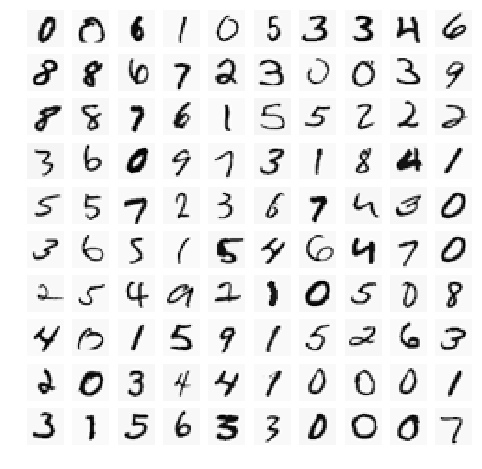

In [334]:
displayData(examples, nrow, ncol)

<b>1.2 | Model representation</b>

In [343]:
class NeuralNetwork:
    def __init__(self, M, N, L, K, lmbda = 1, randomInit = False):
        self._lmbda = lmbda
        self._M = M
        self._N = N
        self._L = L
        self._K = K
        self._randomInit = randomInit
        
        self._epsilon = round(math.sqrt(6)/math.sqrt(self._N + self._K),2)
        
        self.optimum_weights = None
        self._D1 = None
        self._D2 = None
        
        
    def randInitializeWeights(self):
        theta1 = np.random.uniform(-self._epsilon, self._epsilon, (self._L, self._N + 1)) #25x401
        theta2 = np.random.uniform(-self._epsilon, self._epsilon, (self._K, self._L + 1)) #10x26
        
        return theta1, theta2  
    
    
    def formatY(self, Y):
        m = Y.size
        Y_mat = np.zeros((m,10)) #5000x10

        for i in range(m):
            Y_mat[i][Y[i]-1] = 1
        
        return Y_mat
        
        
    def sigmoidGradient(self, Z):
        return np.multiply(expit(Z),(1-expit(Z)))
    
    
    def train(self, nn_params, Xs, Ys):
        fmin = minimize(method='CG', fun=self.nnCostFunction, jac=True, x0=nn_params, 
            args=(X, Y), options={'maxiter': 50})
        
        return fmin
    
    
    def forwardpropagate(self, Xs, theta1, theta2):        
        a1 = np.insert(Xs, 0, values=np.ones(self._M), axis=1) # 5000x401
    
        z2 = a1.dot(theta1.T) # 5000x401  *  401x25
        a2 = expit(z2) #5000x25

        a2 = np.column_stack((np.ones(Xs.shape[0]),a2)) #5000x26

        z3 = a2.dot(theta2.T) #5000x26  *  26x10
        h = expit(z3) #5000x10

        return a1, z2, a2, z3, h

    
    def nnCostFunction(self, nn_params, Xs, Ys):
        
        """
        The parameters for the neural network are "unrolled" into the vector
        nn_params and need to be converted back into the weight matrices
        
        """
        if self._randomInit == True:
            theta1, theta2 = self.randInitializeWeights()
        else:
            theta1 = nn_params[:self._L*(self._N+1)].reshape(self._L, self._N + 1) #25x401
            theta2 = nn_params[self._L*(self._N+1):].reshape(self._K,(self._L+1)) #10x26

        a1, z2, a2, z3, h = self.forwardpropagate(Xs, theta1, theta2)
        
        #Initiatlisations
        J = 0
        D1 = np.zeros(theta1.shape) #25x401
        D2 = np.zeros(theta2.shape) #10x26
        
        #Cost calculations with regularisation
        for i in range(self._M):
            cost_term = -np.multiply(np.log(h[i,:]), Y_mat[i,:]) -np.multiply(np.log(1-h[i,:]), (1-Y_mat[i,:]))
            J += np.sum(cost_term)
                                                                                       
        J = J / self._M + (self._lmbda/(2*self._M))*(np.sum(np.square(theta1[:,1:])) + np.sum(np.square(theta2[:,1:])))                                                                               
        
        
        #Backpropagation
        for t in range(self._M):
            a1t = a1[t,:]  # (1, 401)
            z2t = z2[t,:]  # (1, 25)
            a2t = a2[t,:]  # (1, 26)
            ht = h[t,:]  # (1, 10)
            yt = Ys[t,:]  # (1, 10)

            d3t = ht - yt  # (1, 10)
            d3t = np.matrix(d3t)
            
            z2t = np.insert(z2t, 0, values=np.ones(1))  # (1, 26)
            d2t = np.multiply((theta2.T * d3t.T).T, self.sigmoidGradient(z2t))  # (1, 26)
            
            D2 += d3t.T.dot(a2t)  #10x26            
            D1 += d2t[:,1:].T.dot(a1t) #25x401
        
        #add the regularisation term
        D1[:,1:] = D1[:,1:]/self._M + self._lmbda*theta1[:,1:]/self._M
        D2[:,1:] = D2[:,1:]/self._M + self._lmbda*theta2[:,1:]/self._M
    
        # Append and unroll gradient
        grad = np.append(D1,D2).reshape(-1)
        
        return J, grad

In [336]:
#Prepare input 
N = X.shape[1] #400 pixels per training sample
M = X.shape[0] #5000 training samples
L = 25 #number of nodes in the hidden layer, exc.bias term
K = len(np.unique(Y)) #10 distinct classes in output layer

#add intercept
Y_mat = np.zeros((M,10)) #5000x10

for i in range(M):
    Y_mat[i][Y[i]-1] = 1

In [337]:
X = np.matrix(X)
Y_mat = np.matrix(Y_mat)

In [338]:
#regularisation parameter = 0
NN = NeuralNetwork(M, N, L ,K, lmbda = 0)
print("Cost is: ",round(NN.nnCostFunction(params, X, Y_mat)[0],6))
print("Expected cost is: 0.287629")
print("Grad shape: ",NN.nnCostFunction(params, X, Y_mat)[1])

Cost is:  0.287629
Expected cost is: 0.287629
Grad shape:  [ 3.09356383e-01  0.00000000e+00  0.00000000e+00 ...  9.66104721e-05
 -7.57736846e-04  7.73329872e-04]


In [339]:
#regularisation parameter = 1
NN = NeuralNetwork(M, N, L, K, lmbda=1)
print("Cost is: ",round(NN.nnCostFunction(params, X, Y_mat)[0],6))
print("Expected cost is: 0.383770")

Cost is:  0.38377
Expected cost is: 0.383770


In [340]:
#regularisation parameter = 3

NN = NeuralNetwork(M, N, L , K, lmbda=3)
print("Cost is: ",round(NN.nnCostFunction(params, X, Y_mat)[0],6))
print("Expected cost is: 0.576051")

Cost is:  0.576051
Expected cost is: 0.576051


In [341]:
#regularisation parameter = 3

NN = NeuralNetwork(M, N, L, K, lmbda=10, randomInit = True)
print("Cost is: ",round(NN.nnCostFunction(params,X, Y_mat)[0],6))

Cost is:  6.604638


<b> 2.6 |  Learning parameters</b>

In [342]:
NN = NeuralNetwork(M, N, L ,K, lmbda = 1, randomInit = True)
fmin = NN.train(params, X, Y_mat)
print("Final cost: ",round(fmin.fun, 6))
    
theta1 = np.matrix(np.reshape(fmin.x[:L * (N + 1)], (L, (N + 1))))  
theta2 = np.matrix(np.reshape(fmin.x[L * (N + 1):], (K, (L + 1))))
    
a1, z2, a2, z3, h = NN.forwardpropagate(X, theta1, theta2) 
    
y_pred = np.array(np.argmax(h, axis=1) + 1)  
    
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, Y)]  
accuracy = (sum(map(int, correct)) / float(len(correct)))  
print ("Accuracy: {0}%".format(accuracy*100))    

Final cost:  6.904499
Accuracy: 97.52%
